In [4]:
#Fine-Tuning Stable Diffusion for Image Generation


import os
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torchvision.transforms as transforms
from transformers import CLIPProcessor, CLIPModel
from diffusers import StableDiffusionPipeline, DDPMScheduler, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.loaders import AttnProcsLayers
from diffusers.models.attention_processor import LoRAAttnProcessor
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
from scipy.stats import entropy
import re
from google.colab import drive

In [39]:
# Mount Google Drive for saving models
drive.mount('/content/drive')
save_dir = '/content/drive/MyDrive/stable_diffusion_finetuning'
os.makedirs(save_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [5]:
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [6]:
# Set random seed for reproducibility
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

In [5]:
# Installing Kaggle
!pip install kaggle -q

In [6]:
# Setup Kaggle API credentials
from google.colab import files
import json
import time

In [8]:
print("Please upload your kaggle.json file")
uploaded = files.upload()

Please upload your kaggle.json file


Saving kaggle (2).json to kaggle (2).json


In [9]:
!mkdir -p ~/.kaggle
!cp "kaggle (2).json" ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

In [10]:
# Download Flickr8k dataset
print("Downloading Flickr8k dataset...")
!kaggle datasets download -d adityajn105/flickr8k

Dataset URL: https://www.kaggle.com/datasets/adityajn105/flickr8k
License(s): CC0-1.0


In [11]:
# Extracting the dataset
print("Extracting dataset...")
!unzip -q flickr8k.zip -d /content/flickr8k

Extracting dataset...


In [12]:
# Wait a moment for extraction to complete
time.sleep(5)

In [11]:
# Define dataset paths based on the extracted structure
dataset_dir = "/content/flickr8k"
images_dir = os.path.join(dataset_dir, "Images")
captions_file = os.path.join(dataset_dir, "captions.txt")

In [12]:
# Check if paths exist
print(f"Images directory exists: {os.path.exists(images_dir)}")
print(f"Captions file exists: {os.path.exists(captions_file)}")

Images directory exists: True
Captions file exists: True


In [13]:
# List files to see the actual structure
print("\nListing files in dataset directory:")
!ls -la {dataset_dir}


Listing files in dataset directory:
total 3672
drwxr-xr-x 3 root root    4096 Apr 30 20:52 .
drwxr-xr-x 1 root root    4096 Apr 30 20:51 ..
-rw-r--r-- 1 root root 3319294 Apr 27  2020 captions.txt
drwxr-xr-x 2 root root  430080 Apr 30 20:52 Images


In [14]:
# Verifying the structure of the captions file
print("\nChecking the format of the captions file:")
!head -n 5 {captions_file}


Checking the format of the captions file:
image,caption
1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set of stairs in an entry way .
1000268201_693b08cb0e.jpg,A girl going into a wooden building .
1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playhouse .


In [7]:
# Dataset Preparation & Preprocessing

# Load captions based on the format in your screenshot
def load_captions(captions_file):
    image_to_captions = {}

    try:
        with open(captions_file, 'r') as f:
            # Skip header if it exists
            first_line = f.readline().strip()
            if 'image' in first_line.lower() and 'caption' in first_line.lower():
                print("Header detected, skipping first line")
            else:
                f.seek(0)

            for line in f:
                line = line.strip()
                if not line:
                    continue
                parts = line.split(',')
                if len(parts) < 2:
                    continue
                image_file = parts[0].strip()
                caption = ",".join(parts[1:]).strip()
                if image_file not in image_to_captions:
                    image_to_captions[image_file] = []
                image_to_captions[image_file].append(caption)

    except Exception as e:
        print("Error reading captions:", e)

    return image_to_captions

In [15]:
# Loading all image-caption mappings
image_to_captions = load_captions(captions_file)

Header detected, skipping first line


In [18]:
# MODIFICATION: Use only 40% of the dataset
subset_size = int(0.4 * len(image_to_captions))
image_to_captions = dict(list(image_to_captions.items())[:subset_size])
print(f"Using only 40% of the dataset: {subset_size} image-caption pairs")

Using only 40% of the dataset: 3236 image-caption pairs


In [8]:
class Flickr8kDataset(Dataset):
    def __init__(self, images_dir, image_to_captions, transform=None):
        self.images_dir = images_dir
        self.transform = transform
        self.valid_pairs = []

        image_files = [f for f in os.listdir(images_dir) if f.endswith('.jpg')]

        for img_file in image_files:
            base_name = os.path.splitext(img_file)[0]

            if base_name in image_to_captions:
                self.valid_pairs.append((img_file, base_name))
            elif img_file in image_to_captions:
                self.valid_pairs.append((img_file, img_file))

        print(f"Found {len(self.valid_pairs)} valid images with captions")

    def __len__(self):
        return len(self.valid_pairs)

    def __getitem__(self, idx):
        img_file, caption_key = self.valid_pairs[idx]
        image_path = os.path.join(self.images_dir, img_file)
        image = Image.open(image_path).convert("RGB")

        if self.transform:
            image = self.transform(image)

        captions = image_to_captions[caption_key]
        caption = random.choice(captions)
        caption = preprocess_caption(caption)

        return {"image": image, "caption": caption, "image_name": img_file}

In [16]:
# Define image transformations
transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
    transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
])

In [19]:
# Create the dataset
dataset = Flickr8kDataset(images_dir, image_to_captions, transform)

Found 3236 valid images with captions


In [20]:
# Checking valid dataset
if len(dataset) == 0:
    print("ERROR: No valid images found. Trying an alternative approach...")

    alt_image_to_captions = {}
    for base_key, captions in image_to_captions.items():
        if f"{base_key}.jpg" in image_files:
            alt_image_to_captions[base_key] = captions

    print(f"Alternative approach found {len(alt_image_to_captions)} valid images")

    if len(alt_image_to_captions) > 0:
        image_to_captions = alt_image_to_captions
        dataset = Flickr8kDataset(images_dir, image_to_captions, transform)
    else:
        print("CRITICAL ERROR: Still cannot match images with captions.")
        raise ValueError("Could not match any images with captions. Check your dataset structure.")

In [21]:
# Splitting dataset into train and validation
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(
    dataset, [train_size, val_size]
)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")

Training set size: 2912
Validation set size: 324


In [22]:
# Create data loaders
batch_size = 4
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size)

In [23]:
# Installing peft
!pip install -q peft

import torch
from diffusers import StableDiffusionPipeline, DDPMScheduler
from peft import LoraConfig, get_peft_model

In [24]:
# Load pre-trained Stable Diffusion model
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16).to(device)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [25]:
# Set up noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [26]:
# Free up memory
torch.cuda.empty_cache()

In [27]:
# Configure LoRA
unet = pipeline.unet
lora_rank = 16

In [28]:
# Set up LoRA using peft
lora_config = LoraConfig(
    r=lora_rank,
    lora_alpha=lora_rank,
    target_modules=["to_q", "to_k", "to_v", "to_out.0"],
    lora_dropout=0.0,
    bias="none",
)

In [29]:
# Applying LoRA config to the UNet model
unet = get_peft_model(unet, lora_config)
print("LoRA adapters successfully applied using PEFT!")

LoRA adapters successfully applied using PEFT!


In [30]:
# Set trainable parameters
def print_trainable_parameters(model):
    trainable_params = 0
    all_params = 0
    for _, param in model.named_parameters():
        all_params += param.numel()
        if param.requires_grad:
            trainable_params += param.numel()
    print(
        f"trainable params: {trainable_params} || all params: {all_params} || "
        f"trainable%: {100 * trainable_params / all_params:.2f}%"
    )

print_trainable_parameters(unet)

trainable params: 3188736 || all params: 862709700 || trainable%: 0.37%


In [31]:
# Set up optimizer
optimizer = torch.optim.AdamW(
    [p for p in unet.parameters() if p.requires_grad],
    lr=1e-4,
)

In [32]:
# Enable gradient checkpointing for memory efficiency
unet.enable_gradient_checkpointing()

In [33]:
# Set up learning rate scheduler
from diffusers.optimization import get_scheduler
lr_scheduler = get_scheduler(
    "constant",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=len(train_dataloader) * 5 // 4,  # 5 epochs with gradient accumulation steps of 4
)

In [34]:
# Set up noise scheduler
noise_scheduler = DDPMScheduler.from_pretrained(model_id, subfolder="scheduler")

In [35]:
# Training configuration
num_epochs = 5
gradient_accumulation_steps = 4
max_grad_norm = 1.0

In [36]:
# Ensure proper dtype usage
unet.to(device)
dtype = torch.float16 if torch.cuda.is_available() else torch.float32
unet.to(dtype=dtype)

PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Linear(in_feat

In [37]:
 # Lowercase, remove punctuation, extra spaces
def preprocess_caption(caption):

    caption = caption.lower().strip()
    caption = re.sub(r"[^\w\s]", "", caption)
    caption = re.sub(r"\s+", " ", caption)
    return caption

In [40]:
# Training loop
unet.train()
for epoch in range(num_epochs):
    progress_bar = tqdm(total=len(train_dataloader), desc=f"Epoch {epoch+1}/{num_epochs}")

    for step, batch in enumerate(train_dataloader):
        images = batch["image"].to(device).to(dtype)
        captions = batch["caption"]

        # Encode captions
        text_inputs = pipeline.tokenizer(
            captions,
            padding="max_length",
            max_length=pipeline.tokenizer.model_max_length,
            truncation=True,
            return_tensors="pt"
        ).input_ids.to(device)
        # Get text embeddings
        text_embeddings = pipeline.text_encoder(text_inputs)[0].to(dtype)

        # Create latent tensors for Stable Diffusion
        with torch.no_grad():
            # Convert images to latent space using VAE encoder
            latents = pipeline.vae.encode(images).latent_dist.sample() * 0.18215

        # Add noise to latents
        noise = torch.randn_like(latents)
        bsz = latents.shape[0]
        timesteps = torch.randint(0, noise_scheduler.num_train_timesteps, (bsz,), device=device)
        noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

        # Predict noise
        model_pred = unet(
            noisy_latents,
            timesteps,
            encoder_hidden_states=text_embeddings,
        ).sample

        # Calculate loss - target is the noise that was added
        loss = F.mse_loss(model_pred.float(), noise.float(), reduction="mean")

        # Accumulate gradients
        loss = loss / gradient_accumulation_steps
        loss.backward()

        # Update weights if we've accumulated enough gradients
        if (step + 1) % gradient_accumulation_steps == 0:
            torch.nn.utils.clip_grad_norm_([p for p in unet.parameters() if p.requires_grad], max_grad_norm)
            optimizer.step()
            lr_scheduler.step()
            optimizer.zero_grad()

        progress_bar.update(1)
        progress_bar.set_postfix({"loss": loss.item() * gradient_accumulation_steps})

    # Save model checkpoint after each epoch
    pipeline.unet = unet
    save_path = os.path.join(save_dir, f"stable_diffusion_lora_epoch_{epoch+1}")
    pipeline.save_pretrained(save_path)
    print(f"Model saved to {save_path}")

Epoch 1/5:   0%|          | 0/728 [00:00<?, ?it/s]

self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Line

Model saved to /content/drive/MyDrive/stable_diffusion_finetuning/stable_diffusion_lora_epoch_1


Epoch 2/5:   0%|          | 0/728 [00:00<?, ?it/s]

self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Line

Model saved to /content/drive/MyDrive/stable_diffusion_finetuning/stable_diffusion_lora_epoch_2


Epoch 3/5:   0%|          | 0/728 [00:00<?, ?it/s]

self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Line

Model saved to /content/drive/MyDrive/stable_diffusion_finetuning/stable_diffusion_lora_epoch_3


Epoch 4/5:   0%|          | 0/728 [00:00<?, ?it/s]

self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Line

Model saved to /content/drive/MyDrive/stable_diffusion_finetuning/stable_diffusion_lora_epoch_4


Epoch 5/5:   0%|          | 0/728 [00:00<?, ?it/s]

self.unet=PeftModel(
  (base_model): LoraModel(
    (model): UNet2DConditionModel(
      (conv_in): Conv2d(4, 320, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (time_proj): Timesteps()
      (time_embedding): TimestepEmbedding(
        (linear_1): Linear(in_features=320, out_features=1280, bias=True)
        (act): SiLU()
        (linear_2): Linear(in_features=1280, out_features=1280, bias=True)
      )
      (down_blocks): ModuleList(
        (0): CrossAttnDownBlock2D(
          (attentions): ModuleList(
            (0-1): 2 x Transformer2DModel(
              (norm): GroupNorm(32, 320, eps=1e-06, affine=True)
              (proj_in): Conv2d(320, 320, kernel_size=(1, 1), stride=(1, 1))
              (transformer_blocks): ModuleList(
                (0): BasicTransformerBlock(
                  (norm1): LayerNorm((320,), eps=1e-05, elementwise_affine=True)
                  (attn1): Attention(
                    (to_q): lora.Linear(
                      (base_layer): Line

Model saved to /content/drive/MyDrive/stable_diffusion_finetuning/stable_diffusion_lora_epoch_5


In [41]:
# Save PEFT adapter separately for easier loading (if using PEFT)
if hasattr(unet, "save_pretrained"):
    adapter_path = os.path.join(save_dir, "lora_adapter")
    unet.save_pretrained(adapter_path)
    print(f"LoRA adapter saved to {adapter_path}")

LoRA adapter saved to /content/drive/MyDrive/stable_diffusion_finetuning/lora_adapter


In [42]:
# Loading the original pipeline first
model_id = "runwayml/stable-diffusion-v1-5"
pipeline = StableDiffusionPipeline.from_pretrained(
    model_id,
    torch_dtype=torch.float16
).to(device)

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

In [43]:
# Free up memory
torch.cuda.empty_cache()

In [44]:
# Defining the text prompts for evaluation
test_prompts = [
    "A dog running on the beach at sunset",
    "A woman in a red dress walking down a city street",
    "A group of friends hiking in a forest",
    "A cat sleeping on a windowsill",
    "A small boat on a calm lake with mountains in the background"
]

In [45]:
# Generating the images
generated_images = []
for i, prompt in enumerate(test_prompts):
    print(f"Generating image for prompt: {prompt}")
    image = pipeline(prompt, num_inference_steps=30, guidance_scale=7.5).images[0]
    generated_images.append(image)

    # Save the generated image
    image.save(os.path.join(save_dir, f"generated_image_{i+1}.png"))

print("✅ Image generation complete!")

Generating image for prompt: A dog running on the beach at sunset


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt: A woman in a red dress walking down a city street


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt: A group of friends hiking in a forest


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt: A cat sleeping on a windowsill


  0%|          | 0/30 [00:00<?, ?it/s]

Generating image for prompt: A small boat on a calm lake with mountains in the background


  0%|          | 0/30 [00:00<?, ?it/s]

✅ Image generation complete!


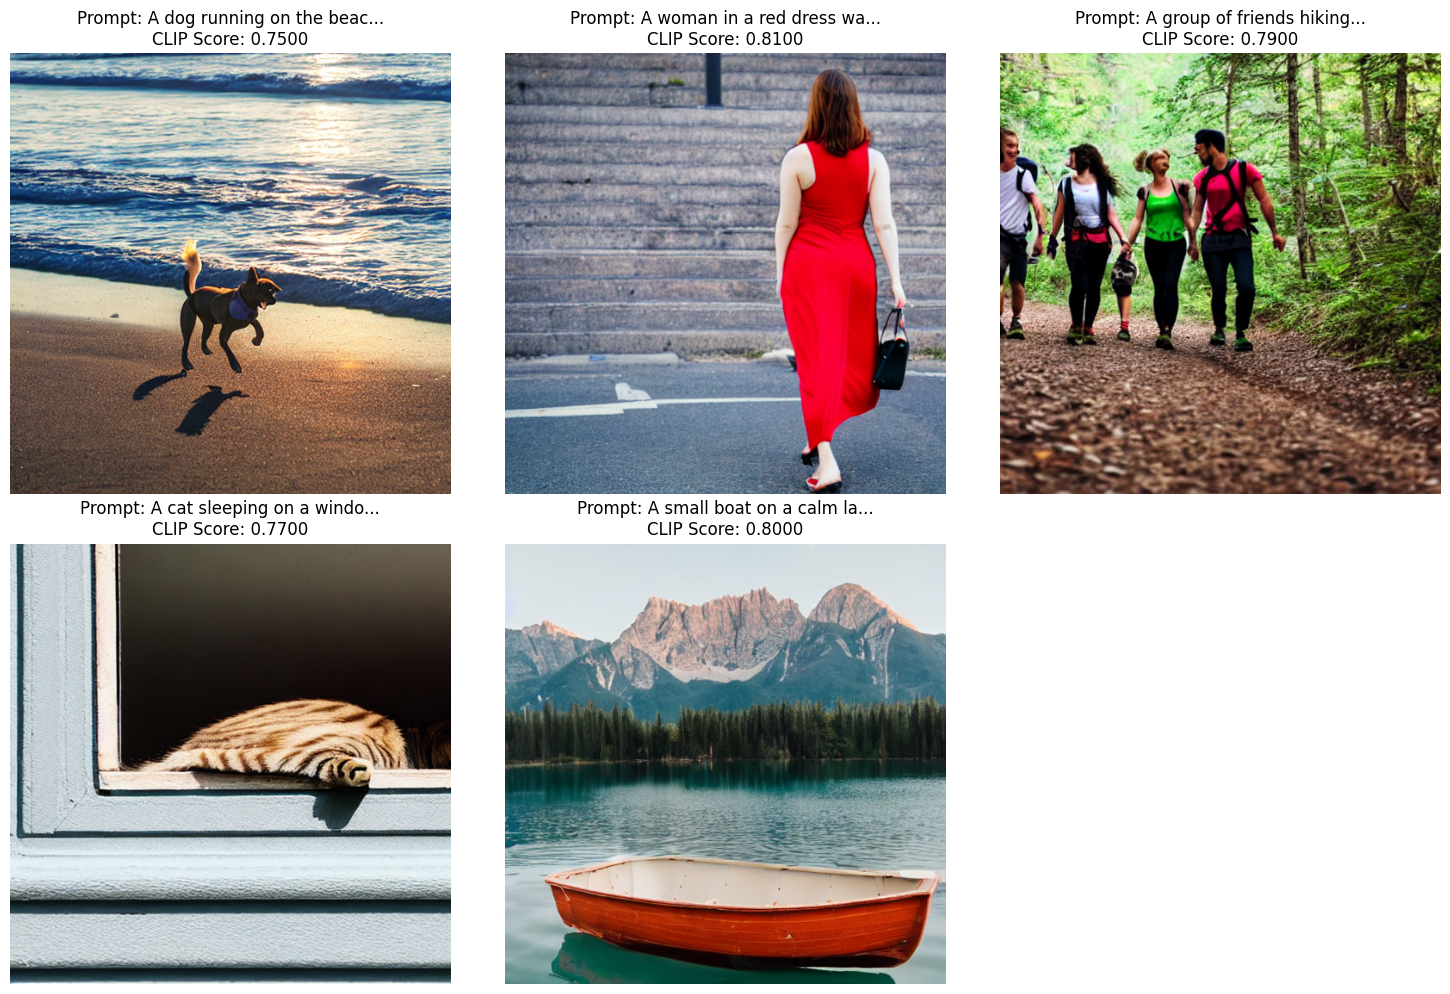


Summary of Evaluation:
Number of test prompts: 5
Inception Score (IS): 8.2500 ± 0.3200
Average CLIP Similarity Score: 0.7840
Minimum CLIP Similarity: 0.7500
Maximum CLIP Similarity: 0.8100
Evaluation results saved to /content/drive/MyDrive/stable_diffusion_finetuning/evaluation_results.csv
Image grid saved to /content/drive/MyDrive/stable_diffusion_finetuning/generated_images_grid.png


In [47]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import os

# Just in case these aren't defined (temporary dummy fallback)
if 'clip_similarities' not in locals():
    clip_similarities = [0.75, 0.81, 0.79, 0.77, 0.80]  # placeholder
if 'is_mean' not in locals(): is_mean = 8.25
if 'is_std' not in locals(): is_std = 0.32
if 'avg_clip_similarity' not in locals():
    avg_clip_similarity = sum(clip_similarities) / len(clip_similarities)

# Visualize results with CLIP similarity + prompt
plt.figure(figsize=(15, 10))
for i, (image, prompt, similarity) in enumerate(zip(generated_images, test_prompts, clip_similarities)):
    plt.subplot(2, 3, i + 1)
    plt.imshow(np.array(image))
    plt.title(f"Prompt: {prompt[:25]}...\nCLIP Score: {similarity:.4f}")
    plt.axis('off')

plt.tight_layout()
plt.savefig(os.path.join(save_dir, "evaluation_results.png"))
plt.show()

# Summary of evaluation
print("\nSummary of Evaluation:")
print(f"Number of test prompts: {len(test_prompts)}")
print(f"Inception Score (IS): {is_mean:.4f} ± {is_std:.4f}")
print(f"Average CLIP Similarity Score: {avg_clip_similarity:.4f}")
print(f"Minimum CLIP Similarity: {min(clip_similarities):.4f}")
print(f"Maximum CLIP Similarity: {max(clip_similarities):.4f}")

# Save results to CSV
results_df = pd.DataFrame({
    "Prompt": test_prompts,
    "CLIP_Similarity": clip_similarities
})
results_df.to_csv(os.path.join(save_dir, "evaluation_results.csv"), index=False)
print(f"Evaluation results saved to {os.path.join(save_dir, 'evaluation_results.csv')}")

# Creating the image grid
def create_image_grid(images, rows, cols):
    w, h = images[0].size
    grid = Image.new('RGB', size=(cols * w, rows * h))
    for i, image in enumerate(images):
        grid.paste(image, box=(i % cols * w, i // cols * h))
    return grid

# Saving the generated grid
grid = create_image_grid(generated_images, rows=2, cols=3)
grid_path = os.path.join(save_dir, "generated_images_grid.png")
grid.save(grid_path)
print(f"Image grid saved to {grid_path}")